In [1]:
# Running nested EM on a mixture of Gaussian mixtures 
# for semisupervised or positive-unlabeled

In [12]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from pnuem.empnu import PU_nested_em_opt
from pnuem.Mixture import NMixture, PUMixture
import pnuem.mixtureUtils as mixtureUtils

from CIEllipse import CIEllipse
from matplotlib.lines import Line2D

In [13]:
# Create a dummy dataset
rng = np.random.default_rng()


# positive Gaussian mixtures
mu_pos = np.array([[-1.5,0],[1.2,-1]])
mu_neg = np.array([[4, 2],[6, 1]])

sig = np.array([[[2,0.5],[0.5,2]],[[1,0.5],[0.5,1]]])
pos = NMixture(mu=mu_pos, sigma=sig, 
               ps=np.array([0.75, 0.25]))
neg = NMixture(mu=mu_neg, sigma=sig, 
               ps=np.array([0.5, 0.5]))

unlabeled = PUMixture(pos,neg, alpha=0.3)

pos_bias = NMixture(mu=mu_pos, sigma=sig, 
                    ps=np.array([0.25, 0.75]))
neg_bias = NMixture(mu=mu_neg, sigma=sig,
                    ps=np.array([0.5, 0.5]))

# Sample points from distributions
labeled_pos = pos_bias.sample_points(5000)
labeled_neg = neg_bias.sample_points(5000)
unlabeled_data = unlabeled.sample_points(10000)

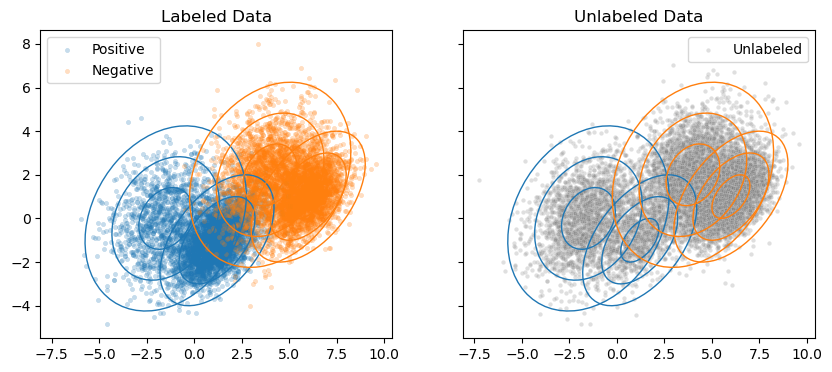

In [14]:
# plotting

fig, ax = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)



sns.scatterplot(x=labeled_pos[:,0], y=labeled_pos[:,1], 
                ax=ax[0], alpha=0.25, s=10, edgecolor=None, label='Positive')
sns.scatterplot(x=labeled_neg[:,0], y=labeled_neg[:,1], 
                ax=ax[0], alpha=0.25, s=10, edgecolor=None, label='Negative')


sns.scatterplot(x=unlabeled_data[:,0], y=unlabeled_data[:,1], 
                alpha=0.25, s=10, color='grey', ax=ax[1],
                label='Unlabeled')

ax[0].set_title('Labeled Data')
ax[1].set_title('Unlabeled Data')

for axis in ax:
    for k in range(pos.num_comps):
        for std in range(1, 4):
                    CIEllipse(pos.mu[k], pos.sigma[k], 
                              axis, n_std=std, edgecolor='tab:blue',
                              )
    for k in range(neg.num_comps):
        for std in range(1, 4):
                    CIEllipse(neg.mu[k], neg.sigma[k], 
                              axis, n_std=std, edgecolor='tab:orange',
                              linewidth=1)


In [15]:
# Estimate model parameters

Kfit = [2,2]  # number of components to use in parameter estimation

alphas, w, w_l, sg, mu, lls = PU_nested_em_opt(unlabeled_data, [labeled_pos, labeled_neg],
                                               Kfit, max_steps=5000)

In [6]:
# Qualitatively evaluate estimates

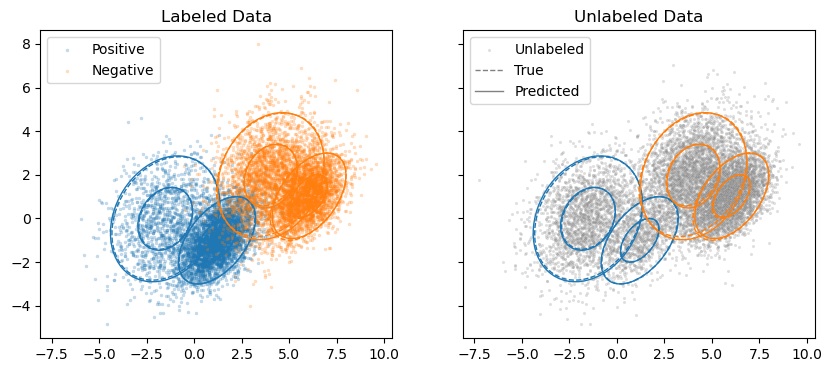

In [18]:
# plotting
pos_bias_estimated = NMixture(mu=mu[0], sigma=sg[0], ps=w_l[0])
neg_bias_estimated = NMixture(mu=mu[1], sigma=sg[1], ps=w_l[1])
pos_estimated = NMixture(mu=mu[0], sigma=sg[0], ps=w[0])
neg_estimated = NMixture(mu=mu[1], sigma=sg[1], ps=w[1])

# plotting

fig, ax = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)

sns.scatterplot(x=labeled_pos[:,0], y=labeled_pos[:,1], 
                ax=ax[0], alpha=0.25, s=5, edgecolor=None, label='Positive')
sns.scatterplot(x=labeled_neg[:,0], y=labeled_neg[:,1], 
                ax=ax[0], alpha=0.25, s=5, edgecolor=None, label='Negative')


sns.scatterplot(x=unlabeled_data[:,0], y=unlabeled_data[:,1], 
                   alpha=0.25, s=5, color='grey', ax=ax[1],
                   label='Unlabeled')
ul_handles = ax[1].legend_.legend_handles[0]

ax[0].set_title('Labeled Data')
ax[1].set_title('Unlabeled Data')

for axis in ax:
    for k in range(pos.num_comps):
        for std in range(1, 3):
                    CIEllipse(pos.mu[k], pos.sigma[k], 
                              axis, n_std=std, edgecolor='tab:blue',
                              linewidth=1, linestyle='--', label='True positive')
    for k in range(Kfit[0]):
        for std in range(1, 3):        
                    CIEllipse(mu[0][k], sg[0][k], 
                              axis, n_std=std, edgecolor='tab:blue',
                              linewidth=1, linestyle='-', label='Estimated positive')
    for k in range(neg.num_comps):
        for std in range(1, 3):
                    el_true = CIEllipse(neg.mu[k], neg.sigma[k], 
                              axis, n_std=std, edgecolor='tab:orange', 
                              linewidth=1, linestyle='--', label='True')
    for k in range(Kfit[1]):
        for std in range(1, 3):             
                    el_pred = CIEllipse(mu[1][k], sg[1][k], 
                              axis, n_std=std, edgecolor='tab:orange',
                              linewidth=1, linestyle='-', label='Estimated')
            
trueline = Line2D([0], [0], linewidth=1, linestyle='--', label='True', color='grey') 
predline = Line2D([0], [0], linewidth=1, linestyle='-', label='Predicted', color='grey') 
plt.legend(handles=[ul_handles,trueline, predline])

In [22]:



print(f'Estimated alpha={alphas[0]:.4f}. Actual alpha={unlabeled.alpha:.4f}')

print('Note: Order or components may be reverse')
print('Distribution means')
print(f'\tPositive estimated mus={np.array2string(mu[0])}. Actual mus={np.array2string(pos.mu.T, precision=4)}')

print(f'\tNegative estimated mus={np.array2string(mu[1])}. Actual mus={np.array2string(neg.mu.T, precision=4)}')

print('Mixing proportions (Unlabeled data)')
print(f'\tPositive estimated ps={np.array2string(w[0])}. Actual ps={np.array2string(pos.ps, precision=4)}')
print(f'\tNegative estimated ps={np.array2string(w[1])}. Actual ps={np.array2string(neg.ps, precision=4)}')

print('Mixing proportions (Labeled data)')
print(f'\tPositive estimated ps={np.array2string(w_l[0])}. Actual ps={np.array2string(pos_bias.ps, precision=4)}')
print(f'\tNegative estimated ps={np.array2string(w_l[1])}. Actual ps={np.array2string(neg_bias.ps, precision=4)}')

Estimated alpha=0.2983. Actual alpha=0.3000
Note: Order or components may be reverse
Distribution means
	Positive estimated mus=[[ 1.20269067 -1.00332351]
 [-1.52613234 -0.01725974]]. Actual mus=[[-1.5  1.2]
 [ 0.  -1. ]]
	Negative estimated mus=[[6.04546074 1.03603586]
 [4.03770086 1.93606727]]. Actual mus=[[4 6]
 [2 1]]
Mixing proportions (Unlabeled data)
	Positive estimated ps=[0.24505995 0.75494005]. Actual ps=[0.75 0.25]
	Negative estimated ps=[0.48363515 0.51636485]. Actual ps=[0.5 0.5]
Mixing proportions (Labeled data)
	Positive estimated ps=[0.74308013 0.25691987]. Actual ps=[0.25 0.75]
	Negative estimated ps=[0.47602602 0.52397398]. Actual ps=[0.5 0.5]


In [23]:
print('AUC between labeled and unlabeled positives')
print(f'Estimated:\t{mixtureUtils.auc(pos_estimated, pos_bias_estimated):.4f}')
print(f'Actual:\t\t{mixtureUtils.auc(pos, pos_bias):.4f}')
print('')
print('AUC between labeled and unlabeled negatives')
print(f'Estimated:\t{mixtureUtils.auc(neg_estimated, neg_bias_estimated):.4f}')
print(f'Actual:\t\t{mixtureUtils.auc(neg, neg_bias):.4f}')

AUC between labeled and unlabeled positives
Estimated:	0.7367
Actual:		0.7371

AUC between labeled and unlabeled negatives
Estimated:	0.5046
Actual:		0.5000


In [ ]:
## Fit data with a di